In [1]:
# -*- coding: utf-8 -*-
"""
Definition of Grid class.
A Grid class instance stores a Modflow Grid (rectangular with variable z).
It is used as both a grid container to pass a grid to functions
and as a server to requist numerous grid properties for instance
necessary for plotting. These properties can becomputed on the fly
and need not be storedr.
The Grid class also performs error checking.

Created on Fri Sep 30 04:26:57 2016

@author: Theo
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path as Polygon
#import pdb

def AND(*args):
    L = args[0]
    for arg in args:
        L = np.logical_and(L, arg)
    return L

def OR(*args):
    L = args[0]
    for arg in args:
        L = np.logical_or(L, arg)
    return L

NOT = np.logical_not

intNaN = -999999

def unique(x, tol=0.0001):
    """Return sorted unique values of x within tolerance """
    x = np.sort(x)
    return x[np.hstack((np.diff(x) > +tol, True))]

def cleanU(U, iu):
    """Clean up relative coordinates U, iu

    Clean up relative coordiantes U, iu such that
    U lies between 0 and 1 (within a cell) and iu is
    the cell number. The point is inside the model
    if the cell number >=0 and <Nx or likwise
    Ny and Nz for the other two directions.
    """
    U     = np.array(U,  dtype=float)
    iu    = np.array(iu, dtype=int)
    shift = np.array(U,  dtype=int)  # integer part of U
    shift[U < 0] -= 1
    U  -=  shift  # now U is between 0 and 1
    iu +=  shift  # iu is update pointing at cell where point is
    return U, iu


class Grid:
    '''Defines a class to hold 3D finite difference grids.

    Grid instances are 3D finite difference grids having many properties
    that can be computed when requested. It can also plot itself.

    Attributes
    ----------
        `axial` : bool
            If true interpret grid as axially symmetric, ignore y-values
        `min_dz` : float
            Mininum layer thickness to enforce

    Methods
    -------
        `plot(linespec)`
            Plot the grid

    Examples
    --------
    gr = Grid(x, y, z, axial=False)
    gr.plot('r-')

    Obtaining grid property values:
    gr.Nx, gr.Ny, gr.Nz, gr.shape, gr.xm, gr.ym, gr.zm etc. etc.

    TO 160930
    '''

    def __init__(self, x, y, z, axial=False, min_dz=0.001, tol=1e-5):
        '''grid constructor

        Parameters
        ----------
            `x` : arraylike
                x-coordinates of the grid lines.
                Will be made unique and ascending.
            `y` : arraylike
                y-coordinates of the grid lines.
                Will be made unique. Use [-0.5 0.5] for cross sections
                also when they are axial
            `z` : arraylike
                z-coordinates of the grid cells' tops and bottoms
                z may be a vector, implying all z-planes are horizontal. The
                vector holds tops and bottoms of these layers. The length
                of z, therefore is one more than the number of layers. `z`
                as a vector will be made unique and descending.

                z may be a full 3D array holding tops and bottoms of a cells.
                The length of z in the 3rd dimension is one more than the
                number of layers.
                z will be make unique and descending in 3d dimension.
            `axial` : bool
                If True grid is assumed axially symmetric interpreing x as r
                and ignoring actual y-coordinates.
                If False grid is assumed linear (regular)
            `min_dz` : float
                Mininum layer thickness to be enforced (top down)
            `tol : float
                Difference in x and y coordinates above with coordinates are
                considered distinct. Coordinates will be rounded to tol before
                applying uninque to them
        '''

        self.AND = np.logical_and
        self.NOT = np.logical_not

        self.intNaN = -9999

        self.axial = axial
        self._min_dz = min_dz
        self._tol = tol
        self._digits = int(abs(np.log10(tol)))

        if y is None:
            y = np.array([-0.5, 0.5])

        x = np.round(np.array(x, dtype=float), self._digits)
        y = np.round(np.array(y, dtype=float), self._digits)

        self._x = np.unique(x)
        self._Nx= len(self._x) - 1

        self._y = unique(y)[::-1]  # always backward
        self._Ny = len(self._y) - 1

        # Check shape of z:
        #   It may be a vector for grids having horizontal layers
        #   or a 3D array where the layers correspond with tops and bottoms at the cell centers.
        if len(z.shape) == 1: # z is given as a vector (tops and bottoms of layers)
            self._full = False
            # unique and put diecton upward increasing
            self._Z = np.array(np.unique(z)[::-1], dtype=float)
            # enforce min_dz
            dz = np.fmax(np.abs(np.diff(self._Z)), self._min_dz)
            self._Nz = len(dz)
            self._Z = self._Z[0] * np.ones(self._Nz + 1)
            self._Z[1:] -= np.cumsum(dz)
            self._Z = self._Z.reshape((self._Nz + 1, 1, 1))
        elif len(z.shape)==3: # z is given as full 3D grid
            #pdb.set_trace()
            if self._Ny != z.shape[1] or self._Nx != z.shape[2]:
                print("\n\
                    The number of rows and columsn of Z is ({0},{1}).\n\
                    But expected was (Ny, Nx) = (Nrow, Ncol)=({3}, {4}) !\n\
                    Maybe the length of x and or y have been changed by\n\
                    __init__ to eliminate coordinates that are less\n\
                    than tol={2} apart.\n\
                    \n\
                    Remedy:\n\
                     1. Check that the difference between the sorted x coordinates\n\
                        is larger than the default or specified tolerance={2}.\n\
                     2. If so, then check the same for the y coordinates.\n\
                     3. If also correct, verify the size of your Z array.\n\
                        It must have (Ny=Nrows={3}, Nx=Ncol={4}).".
                        format(z.shape[0],z.shape[1],self._tol,
                               self._Ny, self._Nx))
                raise ValueError("See printed message for details")
            else:
                self._full = True
                self._Z = np.array(z, dtype=float)
                self._Nz = self._Z.shape[0] - 1
                # make sure Z runs downward
                if self._Z[0, 0, 0] < self._Z[-1, 0, 0]:
                    self._Z = self._Z[::-1, :, :]
                # guarantee min_dz
                DZ = np.fmax(abs(np.diff(self._Z, axis=0)), self._min_dz)
                self._Z = self._Z[0:1, :, :] * np.ones((self._Nz + 1, 1, 1))
                self._Z[1:, :, :] -= np.cumsum(DZ, axis=0)
        else: # illegal shape
            print("\n\
                    z.shape = {}, but expected was a 1D vector\n\
                    or 3D array (Nz+1, {}, {})".
                          format(z.shape, self._Ny, self._Nx))
            raise ValueError("See printed message for details.")

        self._shape = (self._Nz, self._Ny, self._Nx)

        # axial symmetry or not
        if not isinstance(self.axial, bool):
            print("\n\
                axial={0} must be boolean True or False.\n\
                Remedy:\n\
                use axial=True or axial=False explicitly\n\
                when calling mfgrid.Grid class")
            raise ValueError("See printe message for details.")

        if not isinstance(self._min_dz, float) or self._min_dz <= 0.:
            print("\n\
                  min_dz must be a postive float.\n\
                  Remedy:\n\
                      Use min_dz=value explicitly when calling mfgrid.Grid")
            raise ValueError("See printed message for details.")


    @property
    def full(self):
        '''Boolean, indicating whether the grid is a full grid or one in which the z coordinates
        are the same througout the grid (horionzontal layers only)'''
        return self._full # prevent ref to original

    @property
    def min_dz(self):
        '''Float, min layer thickess (read_only)'''
        return self._min_dz # prevent ref to original

    @property
    def x(self):
        return self._x.copy() # prevent ref. to self._x

    @property
    def y(self):
        '''returns y or Ny..0, steps -1 if axial==True'''
        if self.axial:
            return np.arange(self.Ny, -1., -1.) - 1
        else:
            return self._y.copy() # prevent ref. to self._y

    @property
    def z(self):
        '''average cell top and bottom elevatons [1, 1, Nz+1]'''
        return (self.Z).mean(axis=2).mean(axis=1)

    @property
    def Z(self):
        '''Cell top and bottom elevation [Nz+1, Ny, Nx]'''
        if self._full == False:
            return self._Z * np.ones((1, self.Ny, self.Nx))
        else:
            return self._Z.copy()# prevent ref. to original

    @property
    def shape(self):
        '''Shape of the grid'''
        return self._shape # prevent ref. to original

    @property
    def Nx(self):
        '''Number of columns in the grid'''
        return self.shape[2]

    @property
    def Ny(self):
        '''Number of rows in the grid'''
        return self.shape[1]

    @property
    def Nz(self):
        '''Number of layers in the grid'''
        return self.shape[0]

    @property
    def Nod(self):
        '''Number of cells in the grid'''
        return np.product(self.shape)

    @property
    def NOD(self):
        '''Cell numbers in the grid'''
        return np.arange(self.Nod).reshape(self.shape)

    @property
    def dx(self):
        '''Vector [Nx] of column widths'''
        return np.abs(np.diff(self.x))

    @property
    def dy(self):
        '''Vector [Ny] of row widths'''
        return np.abs(np.diff(self.y))

    @property
    def dz(self):
        '''vector [Nz] of average layer thicknesses'''
        return np.abs(np.diff(self.Z, axis=0).mean(axis=2).mean(axis=1))

    @property
    def Dx(self):
        '''2D array [Ny, Nx] of column widths'''
        return np.ones((self.Ny, 1)) * self.dx.reshape((1, self.Nx))

    @property
    def Dy(self):
        '''2D array [Ny, Nx] of row widths'''
        return self.dy.reshape(self.Ny, 1) * np.ones((1, self.Nx))

    @property
    def DX(self):
        '''3D gid [Ny, Nx, Nz] of column'''
        return np.ones(self._shape) * self.dx.reshape((1, 1, self.Nx))

    @property
    def DY(self):
        '''3D grid [Ny, Nx, Nz] of row widths'''
        return self.dy.reshape((1, self.Ny, 1)) * np.ones(self._shape)

    @property
    def DZ(self):
        '''3D grid [Ny, Nx, Nz] of Layer thicnesses'''
        if self._full == False:
            return np.abs(np.diff(self.Z, axis=0) * np.ones(self._shape))
        else:
            return np.abs(np.diff(self.Z, axis=0))

    @property
    def Area(self):
        '''Area of the cells as a 2D grid [Ny, Nx]'''
        if self.axial:
            return np.pi * (self.x[1:]**2 - self.x[:-1]**2) * \
                np.ones((self.Ny, self.Nx))
        else:
            return self.dx.reshape((1, self.Nx)) * self.dy.reshape((self.Ny,1))

    @property
    def area(self):
        '''Total area of grid (scalar), see Grid.Area for cell areas'''
        return self.Area.sum().sum()

    @property
    def Volume(self):
        '''Volume of cells as a 3D grid [Ny, Nx, Nz'''
        if self.axial:
            return self.Area[np.newaxis, :, :] * self.DZ
        else:
            return self.DX * self.DY * self.DZ

    @property
    def volume(self):
        '''Total volume of grid (scalar), see Grid.Volume for cell volumes'''
        return self.Volume.sum(axis=0).sum(axis=0).sum(axis=0)

    @property
    def xm(self):
        '''Grid column center coordinates vector'''
        return 0.5 * (self.x[:-1] + self.x[1:])

    @property
    def ym(self):
        '''Grid row center coordinates vector'''
        return 0.5 * (self.y[:-1] + self.y[1:])

    @property
    def zm(self):
        '''Layer center coordinates vector'''
        z = self.z
        return 0.5 * (z[:-1] + z[1:])

    @property
    def Xm(self):
        '''Column center coordinates as a 2D grid [Ny, Nx]'''
        return np.ones((self.Ny, 1)) * self.xm.reshape((1, self.Nx))

    @property
    def Ym(self):
        '''Row center coordinates as a 2D grid [Ny, Nx]'''
        return self.ym.reshape((self.Ny, 1)) * np.ones((1, self.Nx))

    @property
    def XM(self):
        '''Column center coordinates as a 3D grid [Nz, Ny, Nx]'''
        return np.ones(self.shape) * self.xm.reshape((1, 1, self.Nx))

    @property
    def YM(self):
        '''Row center coordinates as a 3D grid [Nz, Ny, Nx]'''
        return self.ym.reshape((1, self.Ny, 1)) * np.ones(self.shape)

    @property
    def ZM(self):
        '''Cell center coordinates as a 3D grid [Nz, Ny, Nx]'''
        if self._full == False:
            return self.zm.reshape(self.Nz, 1, 1) * np.ones(self._shape)
        else:
            return 0.5 * (self._Z[:-1, :, :] + self._Z[1:, :, :])

    @property
    def xc(self):
        '''xc cell centers except first and last, they are grid coordinates.
        Convenience property for contouring [Nx]
        '''
        return np.hstack(([self._x[0], self.xm[1:-1], self.x[-1]]))

    @property
    def yc(self):
        '''yc cell centers except first and last, they are grid coordinates.
        Convenience property for contouring [Ny]
        '''
        return np.hstack(([self._y[0], self.ym[1:-1], self.y[-1]]))

    @property
    def zc(self):
        '''zc cell centers except first and last, they are grid coordinates.
        Convenience property for contouring [Ny]
        '''
        return np.hstack(([self.z[0], self.zm[1:-1], self.z[-1]]))

    @property
    def XC(self):
        '''Xc cell centers as a 2D grid [Ny. Nx],
        except first and last columns, they are grid coordinates.
        Convenience property for contouring
        '''
        Xc = self.Xm; Xc[:,0] = self._x[0]; Xc[:,-1] = self._x[-1]
        return Xc

    @property
    def YC(self):
        '''Yc cell centers as a 2D grid [Ny. Nx],
        except first and last columns, they are grid coordinates.
        Convenience property for contouring
        '''
        Yc = self.Ym; Yc[0,:] = self._y[0]; Yc[:,-1] = self._y[-1]
        return Yc

    @property
    def ZC(self):
        '''Zc cell centers as a 2D grid [Nz, Nz] for specified row,
        except first and last columns, which are grid coordinates.
        Convenience property for contouring
        '''
        Zc = self.ZM
        Zc[ 0, :, :] = self._Z[ 0, :, :]
        Zc[-1, :, :] = self._Z[-1, :, :]
        return Zc

    @property
    def xp(self):
        '''xp grid coords vector except first and last [Nx-1].
        Convenience property for plotting stream lines
        '''
        return self._x[1:-1]

    @property
    def zp(self):
        '''zp grid coords, convenience for plotting stream lines [Nz+1]
        rather use Xp with Zp as vertical 2D grid'''
        if self._full == False:
            return self._Z.ravel()
        else:
            return (0.5 * (self._Z[:, :, :-1] + self._Z[:, :, 1:])).\
                        mean(axis=1).mean(axis=1)

    @property
    def Xp(self):
        '''Xp grid coords except first and last as 2D vertical grid [Nz+1, Nx-1]
        Convenience property for plotting stream lines
        '''
        return self._x[1:-1] * np.ones((self.Nz+1, self.Nx-1))

    @property
    def Zp(self, row=0):
        '''Zp grid coords in z-x cross section [Nz+1, Nx-1],
        except first and last as 2D vertical grid.
        Convenience property for plotting stream lines
        '''
        return (0.5 * (self.Z[:, row, :-1] + self.Z[:, row, 1:]))

    @property
    def ZP(self):
        '''Zp grid coords in z-x cross section [Nz+1, Nx-1],
        except first and last as 2D vertical grid.
        Convenience property for plotting stream lines
        '''
        return self.Z[:, :, 1:-1]

    @property
    def zT(self):
        '''ZT elevation of the top of the cells as a 3D grid [Ny, Nx, Nz]'''
        return self.ZT.mean(axis=-1).mean(axis=-1)

    @property
    def zB(self):
        '''ZT elevation of the top of the cells as a 3D grid [Ny, Nx, Nz]'''
        return self.ZB.mean(axis=-1).mean(axis=-1)

    @property
    def ZT(self,row=0):
        '''ZT elevation of the top of the cells as a 3D grid [Ny, Nx, Nz]'''
        return self.Z[:-1, :, :]

    @property
    def ZB(self,row=0):
        '''ZT elevation of the bottom of the cells as a 3D grid [Ny, Nx, Nz]'''
        return self.Z[1:, :, :]

    @property
    def Zgr(self):
        '''Returns Z array of all grid points.

        This array has shape (Nz+1, Ny+1, Nx+1) instead of (Nz+1, Ny, Nx)
        of the Z array. The elevation of the internal grid points is computed
        as the average of that of the 4 surrounding cells given in Z.

        See also plot_grid3d where it is used to plot a 3D wire frame of the
        grid.

        Notice: Zgr is not stored to save memory; it is always computed
        from Z when it is used.
        '''
        shape = (self.Nz + 1, self.Ny + 1, self.Nx + 1)
        Zgr = np.zeros(shape)

        Zgr[  :,    0,  0] = self.Z[ :,  0,  0]
        Zgr[  :,   -1,  0] = self.Z[ :, -1,  0]
        Zgr[  :,    0, -1] = self.Z[ :,  0, -1]
        Zgr[  :,   -1, -1] = self.Z[ :, -1, -1]
        Zgr[  :,  0, 1:-1] = 0.5 * (self.Z[:,  0, 1:] + self.Z[:,  0, :-1])
        Zgr[  :, -1, 1:-1] = 0.5 * (self.Z[:, -1, 1:] + self.Z[:, -1, :-1])
        Zgr[  :, 1:-1,  0] = 0.5 * (self.Z[:, 1:,  0] + self.Z[:, :-1,  0])
        Zgr[  :, 1:-1, -1] = 0.5 * (self.Z[:, 1:, -1] + self.Z[:, :-1, -1])
        Zgr[:, 1:-1, 1:-1] = 0.25 * (
            self.Z[:, :-1,  1:] +
            self.Z[:,  1:,  1:] +
            self.Z[:, :-1, :-1] +
            self.Z[:,  1:, :-1]
            )
        return Zgr

    @property
    def ixyz_corners(self):
        """Returns the indices of all corners of the grid in ix, iy, ix order"""
        idx = [0, -1]
        idy = [0, -1]
        idz = [0, -1]
        RCL = np.zeros((8, 3), dtype=int)
        for ix in range(2):
            for iy in range(2):
                for iz in range(2):
                    k = 4 * iz + 2 * iy + ix
                    RCL[k] = np.array([idz[iz], idy[iy], idx[ix]])
        return RCL # row col lay


    """Methods"""

    def ix(self, xp, left=intNaN, right=intNaN):
        '''Returns index ix of cell where xp is in

        Results always and inlcuding 0 and Nx
        '''
        xp = np.array(xp, ndmin=1, dtype=float)
        ix = np.array( np.interp( xp, self.x, np.arange(self.Nx+1),
                                 left=left, right=right), dtype=int)
        return np.fmin(ix, self.Nx - 1)  # ix always between 0 and Nx-1


    def iy(self, yp, left=intNaN, right=intNaN):
        '''Returns index iy of cell where yp is in.

        Results always between and including 0 and Ny.
        '''
        yp = np.array(yp, ndmin=1, dtype=float)
        iy = np.array( np.interp(-yp,-self.y, np.arange(self.Ny+1),
                                 left=left, right=right), dtype=int)
        return np.fmin(iy, self.Ny - 1)


    def ixyz(self, xp, yp, zp, order='CRL', left=intNaN, right=intNaN):
        '''Returns indices ix, iy,, iz of cell where points (xp, yp, zp) are in.

        Notice: all three inputs are required because z varies per (ix,iy)
        It may be simplified when gr.full = False (uniform layers)

        The indices always resulting in values beteen 0 and the number of cells
        in the respective row, column and layer minus 1. These are legal
        indices. To remove points outside the model, fiter them on their
        coordinates.

        Parameters:
        -----------
            xp : np.ndarray of x-grid coordinates
            yp : np.ndarray of y-grid coordinates
            zp : np.ndarray of z-grid coordinates
            order : order of returned indices tuple
                'CRL' = (Col, Row Layer), same order as input (xp, yp, zp)
                'RCL' = (Row, Col, Layer)
                'LRC' = (Layer, Row, Col) (as wanted by Modflow packaeges)
        Returns:
        --------
        typle of cell indices, see descirption under 'order'
        In the tuple are:
        ix : ndarray of int
            always between and including 0 and Nx-1
        iy : ndarray of int
            always between and including 0 and Ny-1
        iz : ndarray of int
            always between and including 0 and Nz-1

        @TO 161031
        '''
        xp = np.array(xp, ndmin=1, dtype=float)
        yp = np.array(yp, ndmin=1, dtype=float)
        zp = np.array(zp, ndmin=1, dtype=float)

        if not (np.all(xp.shape == yp.shape) and np.all(xp.shape == zp.shape)):
            print("Shapes of xp={}, yp={} and zp={} must match".\
                  format(xp.shape, yp.shape, zp.shape))
            raise ValueError("shapes don't match")

        ix = self.ix(xp)
        iy = self.iy(yp)
        iz = np.zeros(ix.shape, dtype=int) + intNaN

        Lu = ix >= 0
        Lv = iy >= 0

        L = AND(Lu, Lv)
        if self.full == False:
            iz[L] = np.array( np.interp( -zp[L],
                 -self.z, np.arange(self.Nz + 1),
                     left=left, right=right), dtype=int)
        else:
            for i in range(len(zp)):
                if L[i] == True:
                    z = self.Z[:, iy[i], ix[i]]
                    if AND(zp[i] <= z[0], zp[i] >= z[-1]):
                        iz[i] = np.array( np.interp( -zp[i], -z,\
                            np.arange(self.Nz + 1),\
                            left=left, right=right), dtype=int)
        iz = np.fmin(iz, self.Nz - 1)
        if order=='CRL':
            return ix, iy, iz
        elif order == 'LRC':
            return iz, iy, ix
        elif order == 'RCL':
            return iy, ix, iz
        else:
            print("Use 'RCL', 'LRC' or 'RCL' for order.")
            raise ValueError("Unrecognied input, use RCL, LRC or RCL")


    def norm_grid(self):
        """Generate a normalized grid from current grid."""
        up = np.arange(self.Nx + 1, dtype=float)
        vp = np.arange(self.Ny + 1, dtype=float)
        wp = np.arange(self.Nz + 1, dtype=float)
        return Grid(up, vp, wp)


    def ixyz2global_index(self, ix, iy, iz):
        """Returns global cell index given ix, iy and iz."""
        ix = np.array(ix, dtype=int)
        iy = np.array(iy, dtype=int)
        iz = np.array(iz, dtype=int)
        if not (np.all(ix.shape == iy.shape) or np.all(ix.shape == iz.shape)):
            print("The shapes of ix={}, iy={} and iz={} must be the same".\
                  format(ix.shape, iy.shape, iz.shape))
            raise ValueError("Shapes don't match.")

        Iglob = np.zeros(ix.shape, dtype=int) + intNaN

        L = AND(ix >= 0, ix <= self.Nx,
                iy >= 0, iy <= self.Ny,
                iz >= 0, iz <= self.Nx)

        Iglob[L] = iz[L] * self.Nx * self.Ny + iy[L] * self.Nx + ix[L]
        return   Iglob


    def xyz2global_index(self, xp, yp, zp):
        """Returns global cell indices given points wiht grid coords xp, yp zp.

        The shapes of xp, yp and zp must be the same.
        xp, yp, zp are ndarrays of floats or converted to such ndarrays.
        """
        xp = np.array(xp, dtype=float).ravel()
        yp = np.array(yp, dtype=float).ravel()
        zp = np.array(zp, dtype=float).ravel()

        if not (np.all(xp.shape == yp.shape) and np.all(xp.shape == zp.shape)):
            print("shape of xp={}, yp{} and zp{} must be equal.".\
                  format(xp.shape, yp.shape, zp.shape))
            raise ValueError("Sahpes don't match")

        I = self.inside(xp, yp, zp)
        ix = np.ones(xp.shape, dtype=int) * intNaN
        iy = np.ones(yp.shape, dtype=int) * intNaN
        iz = np.ones(zp.shape, dtype=int) * intNaN

        ix[I], iy[I], iz[I] = self.ixyz(xp[I], yp[I], zp[I], order='CRL')
        return self.ixyz2global_index(ix, iy, iz)


    def U(self, xp):
        """"Returns normalized coordinate for xp

        Normalized coordinate runs from 0 to Nx

        returns:
        --------
            U  :  ndarray, dtype=float
                normalized coordinates within column iu
            iu :  ndarray, dtype = int
                column iu in which xp resides
        """
        xp = np.array(xp, ndmin=1, dtype=float).ravel()
        up = self.up(xp)
        iu = np.fmin( np.array(up, dtype=int), self.Nx - 1)
        U = up - iu
        return U, iu


    def V(self, yp):
        """"Returns normalized coordinate for yp

        Normalized coordinate runs from 0 to Ny+1

        returns:
        --------
            V  :  ndarray, dtype=float
                normalized coordinates within row iv
            iv :  ndarray, dtype = int
                row iv in which yp resides
        """
        yp = np.array(yp, ndmin=1, dtype=float).ravel()
        vp = self.vp(yp)
        iv = np.fmin( np.array(vp, dtype=int), self.Ny - 1)
        V = vp - iv
        return V, iv


    def W(self, xp, yp, zp):
        """Returns normalized coordinate for zp.

        xp and yp are needed because z may vary for each ix,iy combination.
        """
        xp = np.array(xp, ndmin=1, dtype=float).ravel()
        yp = np.array(yp, ndmin=1, dtype=float).ravel()
        zp = np.array(zp, ndmin=1, dtype=float).ravel()

        if not ( np.all(xp.shape == yp.shape) and np.all(xp.shape == zp.shape) ):
            print("Shapes of xp={}, yp={} and zp{} must match".\
                  format(xp.shape, yp.shape, zp.shape))
            raise ValueError("Shapes don't match.")

        wp = self.wp(xp, yp, zp)
        iw = np.fmin( np.array(wp, dtype=int), self.Nz - 1)
        W = wp - iw
        return W, iw


    def up(self, xp, left=None, right=None):
        """Returns normallized coordinate along x axis (0 to Nx+1)

        Any point outside the range will projected onto the left or right edge.
        So up<0 -> 0 and up>Nx -> Nx

        """
        xp = np.array(xp, ndmin=1, dtype=float).ravel()
        up = np.interp( xp, self.x, np.arange(self.Nx+1),
                       left=left, right=right)
        return up # up will always be between 0 and Nx + 1


    def vp(self, yp, left=None, right=None):
        """Returns normalized coordinate along y axis (0 to Ny+1)

        Any point outside the range will projected onto the left or right edge.
        So up<0 -> 0 and up>Ny -> Ny

        """
        yp = np.array(yp, ndmin=1, dtype=float).ravel()
        vp = np.interp(-yp,-self.y, np.arange(self.Ny+1),
                       left=left, right=right)
        return vp


    def wp(self, xp, yp, zp, left=None, right=None):
        """Returns normalized coordinate along z axis (0 to Nz+1"""
        xp = np.array(xp, ndmin=1, dtype=float).ravel()
        yp = np.array(yp, ndmin=1, dtype=float).ravel()
        zp = np.array(zp, ndmin=1, dtype=float).ravel()

        if not (np.all(xp.shape == yp.shape) and np.all(xp.shape == zp.shape)):
            print("Shapes of xp={}, yp={} and zp{} must match".\
                  format(xp.shape, yp.shape, zp.shape))
            raise ValueError("Shapes don't match.")

        iu = self.ix(xp) # always between 0 and Nx - 1
        iv = self.iy(yp) # always between 0 and Nz - 1

        Lu = AND(xp >= self.x[ 0], xp <= self.x[-1])
        Lv = AND(yp >= self.y[-1], yp <= self.y[ 0])

        L = AND(Lu, Lv)
        wp = np.zeros(zp.shape, dtype=float) * np.NaN
        if self.full == False:
            wp = np.interp( -zp, -self.z, np.arange(self.Nz+1),
                           left=left, right=right)
        else:
            for i in range(len(L)):
                if L[i] == True:
                    wp[i] = np.interp( -zp[i], -self.Z[:, iv[i], iu[i]],\
                        np.arange(self.Nz+1) ,\
                            left=left, right=right)
        return wp # always between 0 and Nz


    def xyz2uvw(self, xp, yp, zp, left=np.NaN, right=np.NaN):
        """"Returns normalized coordinate for xp, yp, zp

        Normalized coordinate runs from 0 to Nx+1,0 to Ny+1 and 0 to Nz+1

        Parameters:
        ----------
        xp : ndarray, x-coordinates in grid
        yp : ndarray, y-coordinates in grid
        zp : ndarray, z-coordinates in grid

        returns:
        --------
            up  :  ndarray, dtype=float, 0 to Nx+1
                normalized coordinate in column of xp
            vp  :  ndarray, dtype=float, 0 to Ny+1
                normalized coordinates within row yp
            wp :  ndarray, dtype = float, 0 to Nz+1
                normalized coordinates within col-row of zp
        @ TO161031
        """
        xp = np.array(xp, ndmin=1, dtype=float).ravel()
        yp = np.array(yp, ndmin=1, dtype=float).ravel()
        zp = np.array(zp, ndmin=1, dtype=float).ravel()

        if not (np.all(xp.shape == yp.shape) and np.all(xp.shape == zp.shape)):
            print("xp.shape={} and yp.shape={} and or zp.shape={} do not match.".\
                  format(xp.shape, yp.shape, zp.shape))
            raise ValueError("Shapes don't match.")

        up = self.up(xp) # always between 0 and Nx
        vp = self.vp(yp) # always between 0 and Ny
        wp = self.wp(xp, yp, zp, left, right) # always between 0 and Ny
        return up, vp, wp


    def uvw2xyz(self, up,vp,wp):
        """From nomalized coords (up, vp, wp) to grid coords (xp, yp, zp)

        Whatever the normalized coordinates are,
        the resulting grid coordinates will always be between
        and including the extreme grid coordinates. That is
        points outside the model will be project on its outer boundaries.

        This prevents NaNs. To eliminate such points filter the input.
        """

        def LOCAL(up, Nx):
            """Return local coordinates u,iy given normalized coordinate up
            """
            iu = np.fmin( np.array(up, dtype=int), Nx - 1)
            u = up - iu
            return u, iu


        # Notice that underscores are used to prevent confusion with pdb cmds
        up = np.array(up, ndmin=1, dtype=float).ravel()
        vp = np.array(vp, ndmin=1, dtype=float).ravel()
        wp = np.array(wp, ndmin=1, dtype=float).ravel()

        if not (np.all(up.shape == vp.shape) and np.all(up.shape==wp.shape)):
            print("up.shape={} and vp.shape={} and or wp.shape={} do not match".\
                  format(up.shape, vp.shape, wp.shape))
            raise ValueError("Shapes don't match.")

        U, iu = LOCAL(up, self.Nx)
        V, iv = LOCAL(vp, self.Ny)
        W, iw = LOCAL(wp, self.Nz)

        L = AND(up >= 0, up <= self.Nx,\
                vp >= 0, vp <= self.Ny,\
                wp >= 0, wp <= self.Nz)

        xp = np.zeros(up.shape, dtype=float) * np.NaN
        yp = np.zeros(vp.shape, dtype=float) * np.NaN
        zp = np.zeros(wp.shape, dtype=float) * np.NaN

        xp[L] = self.x[iu[L]] +  U[L] * self.dx[iu[L]]
        yp[L] = self.y[iv[L]] -  V[L] * self.dy[iv[L]]
        if self.full == False:
            zp[L] = self.z[iw[L]] - W[L] * self.dz[iw[L]]
        else:
            for i in range(len(iw)):
                if L[i]==True:
                    zp[i] = self.Z[iw[i], iv[i], iu[i]] - W[i] *\
                             self.DZ[iw[i], iv[i], iu[i]]
        return xp, yp, zp


    def inside(self, xp, yp, zp):
        """Returns logical array telling which of the points are inside the grid.
        xp, yp and zp must be ndarrays of equal shape of type

        """
        up, vp, wp = self.xyz2uvw(xp, yp, zp)
        return NOT(OR(np.isnan(up), np.isnan(vp), np.isnan(wp)))


    def plot_grid(self,color='c',axes=None, **kwargs):
        '''Plot the grid '''
        from mpl_toolkits.mplot3d import Axes3D
        if axes is None or isinstance(axes, Axes3D):
            fig = plt.figure()
            axes = fig.add_subplot(211, projection='3d')
            # delegate to plot_grid3d
            self.plot_grid3d(color, axes, **kwargs)
        elif isinstance(axes, plt.Axes):
            plt.axes(axes)
            plt.setp(axes, xlabel='x [m]', ylabel='y [m]', title='fdm grid',
                         xlim=self.x[[0,-1]], ylim=self.y[[-1, 0]])
            for x in self.x:
                plt.plot([x, x], self.y[[0,-1]], color, **kwargs)
            for y in self.y:
                plt.plot(self.x[[0,-1]], [y, y], color, **kwargs)
        else:
            print("axes must be a valid 2D or 3D axis not type {}".\
                  format(type(axes)))
            raise ValueError("Incorrect axis type.")
        return axes


    def plot_ugrid(self,color='grb', axes=None, **kwargs):
        '''plot the normlized grid '''
        from mpl_toolkits.mplot3d import Axes3D
        from matplotlib.axes import Axes

        color = color[0:3] if len(color)>3\
                     else color + (3 - len(color)) * color[-1]

        if axes is None:
            axes = plt.figure().add_subplot(211, projection='3d')

        if isinstance(axes, Axes3D):
            #plot 3D
            axes.set_xlim([0, self.Nx])
            axes.set_ylim([0, self.Ny])
            axes.set_zlim([0, self.Nz])
            axes.yaxis_inverted()
            axes.zaxis_inverted()
            for iz in range(self.Nz + 1):
                for ix in range(self.Nx + 1):
                    plt.plot([ix, ix], [0, self.Ny],
                             [iz, iz], color[0], **kwargs)
                for iy in range(self.Ny + 1):
                    plt.plot([0, self.Nx], [iy, iy],
                             [iz, iz], color[1], **kwargs)
            for ix in range(self.Nx + 1):
                for iy in range(self.Ny + 1):
                    plt.plot([ix, ix], [iy, iy],
                             [0, self.Nz], color[2], **kwargs)
        elif isinstance(axes, Axes):
            # plot 2D
            axes.invert_yaxis()
            plt.setp(axes, xlabel='u [-]', ylabel='v [-]',
                     title='normalized fdm grid',
                     xlim=(0, self.Nx), ylim=(self.Ny, 0))
            for u in self.up(self.x):
                plt.plot([u, u], [0, self.Ny], color[0], **kwargs)
            for v in self.vp(self.y):
                plt.plot([0,self.Nx], [v, v], color[1], **kwargs)
        else:
            print("axes must be of type Axes or Axes3D not {}".format(type(axes)))
            raise ValueError("Incorrect axis type.")
        return axes


    def plot_xs(self, color=None, row=0, axes=None):
        '''plot a vertical cross section along a row'''
        if axes is None:
            axes = plt.gca()
            plt.setp(axes, xlabel='z [m]', ylabel='z [m]', title='XS along a row',
                     xlim=self.x[0, -1], ylim=self.z[-1,0])
        if color is None:
            color='c'

        # to plot stair case when z is not uniform
        x = np.hstack((self.x.T, self.x.T)).ravel()
        for iz in range(self.Nz+1):
            z = np.hstack((self._Z[iz, row, :].T, self._Z[iz, row, :].T)).ravel()
            plt.plot(x, z, color)

        zt = np.hstack((self._Z[ 0, row, :].T, self._Z[ 0, row, :].T)).ravel()
        zb = np.hstack((self._Z[-1, row, :].T, self._Z[-1, row, :].T)).ravel()
        for ix in range(2 * (self.Nx+1)):
            plt.plot([x[ix], x[ix]], [zt[ix], zb[ix]], color)
        return axes


    def plot_us(self, color=None, axes=None):
        '''plot a vertical cross section along any row in normalized grid'''
        if axes is None:
            axes = plt.gca()
            plt.setp(axes, xlabel='u [-]', ylabel='v [-]',
                     title='XS normalized grid',
                     xlim=(0, self.Nx+1), ylim=(0, self.Ny+1),
                     ydir='reverse' )
        if color is None:
            color = 'c'
        for v_ in np.arange(self.Nz + 1):
            plt.plot( [0, self.Nx], [v_, v_], color)
        for u_ in np.arange(self.Nx+1):
            plt.plot([u_, u_], [0, self.Ny], color)
        return axes

    def plot_grid3d(self, color='c', ax=None, **kwargs):
        """Plots 3D wire frame of grid

        parameters:
        -----------
        color : str, color of the wire frame lines. One to three characters
            that idicate the wire colors in the, x, y and z directions.
            If less than 3 charaters are used, the last char is used for the
            missing colors.
            examples: 'c', 'cmc', 'cb'
            Default: 'ccc'
        """
        if ax is None:
            ax = plt.gcf().gca(projection='3d') # generate or use current axes
        else:
            ax = plt.axes(ax) # make ax current axes
        # lines in x-direction
        if not isinstance(color, str):
            print("""Color must be one to 3 chars indicateing legal colors\n\
            You supplied <{}>. Legal is for  instnace 'c', 'mc', 'mgc'""".\
                    format(color))
        else:
            clr = color[0:2] if len(color)>3 else color + (3 - len(color)) * color[-1]
        Zgr = self.Zgr
        for iz in range(self.Nz + 1):
            for ix in range(self.Nx + 1):
                x = self.x[ix] * np.ones(self.Ny + 1, dtype=int)
                plt.plot(x, self.y, Zgr[iz, :, ix], clr[0], **kwargs)
            for iy in range(self.Ny + 1):
                y = self.y[iy] * np.ones(self.Nx + 1, dtype=int)
                plt.plot(self.x, y, Zgr[iz, iy, :], clr[1], **kwargs)
        for ix in range(self.Nx + 1):
            x = self.x[ix] * np.ones(self.Nz + 1)
            for iy in range(self.Ny + 1):
                y = self.y[iy] * np.ones(self.Nz + 1)
                plt.plot(x, y, Zgr[:, iy, ix], clr[2], **kwargs)


    def const(self, u):
        """generate an ndarray of gr.shape with value u.
        -----
        u can be a scaler or a vector of shape (Nz,) or (1,1,Nz) in which
        case the values of u are use to set the layers of the array with
        the correspoining value.

        examples:
        U = gr.const(3.), U = gr.const(np.random.randn((1, 1, gr.Nz)))
        U = gr.const(np.random.randn(gr.Nz))

        TO 161007
        """
        if isinstance(u, (float, int)):
            return u * np.ones(self._shape)
        elif isinstance(u, np.ndarray):
            if len(u.ravel()) == self._shape[0]:
                u = u.reshape((self._Nz, 1, 1))
                return u * np.ones(self._shape)
            else:
                raise ValueError("Len of input array not equal to gr.Nz")
        elif isinstance(u, list):
            if len(u) == self._shape[0]:
                u = np.array(u).reshape((self._Nz, 1, 1))
                return u * np.ones(self._shape)
            raise ValueError("len of input list must equal gr.Nz")
        else:
            raise ValueError("Argument must be scalar or array of length gr.Nz")


    def quivdata(self, Out, iz=0):
        """Returns vector data for plotting velocity vectors.

        Takes Qx from fdm3 and returns the tuple X, Y, U, V containing
        the velocity vectors in the xy plane at the center of the cells
        of the chosen layer for plotting them with matplotlib.pyplot's quiver()

        Qx --- field in named tuple returned by fdm3.
        x  --- grid line coordinates.
        y  --- grid line coordinates.
        iz --- layer for which vectors are computed (default 0)

        """
        Ny = self.Ny
        Nx = self.Nx

        X, Y = np.meshgrid(self.xm, self.ym) # coordinates of cell centers

        # Flows at cell centers
        U = np.concatenate((Out.Qx[iz, :, 0].reshape((1, Ny, 1)), \
                            0.5 * (Out.Qx[iz, :, :-1].reshape((1, Ny, Nx-2)) +\
                                   Out.Qx[iz, :, 1: ].reshape((1, Ny, Nx-2))), \
                            Out.Qx[iz, :, -1].reshape((1, Ny, 1))), axis=2).reshape((Ny,Nx))
        V = np.concatenate((Out.Qy[iz, 0, : ].reshape((1, 1, Nx)), \
                            0.5 * (Out.Qy[iz, :-1, :].reshape((1, Ny-2, Nx)) +\
                                   Out.Qy[iz, 1:,  :].reshape((1, Ny-2, Nx))), \
                            Out.Qy[iz, -1, :].reshape((1, 1, Nx))), axis=1).reshape((Ny,Nx))
        return X, Y, U, V


    def inblock(self, xx=None, yy=None, zz=None):
        """Return logical array denoding cells in given block"""
        if xx == None:
            Lx = self.const(0) > -np.inf # alsways false
        else:
            Lx = np.logical_and(self.XM >= min(xx), self.XM <= max(xx))
        if yy== None:
            Ly = self.const(0) > -np.inf  # always false
        else:
            Ly = np.logical_and(self.YM >= min(yy), self.YM <= max(yy))
        if zz == None:
            Lz = self.const(0) > -np.inf  # always false
        else:
            Lz = np.logical_and(self.ZM >= min(zz), self.ZM <= max(zz))
            #L = np.logical_and( np.logical_and(Lx, Ly), Lz)
        return np.logical_and( np.logical_and(Lx, Ly), Lz)

    def inpoly(self, pgcoords, row=None):
        """Returns bool array [Ny, Nx] telling which grid points are inside polygon
            parameters:
            -----------
            pgcoords: like [(0, 1),(2, 3), ...] polygon coordinates
            row: if None, grid is in the xy plane
                if int, then grid is cross section at row
                and pgcoords are interpreted as x,z

        """
        if row is None:
            return inpoly(self.xm, self.ym, pgcoords)
        else:
            Y = self.ZM[row, :, :].T
            X = self.XM[row, :, :].T
            return inpoly(X, Y, pgcoords)

def sinspace(x1, x2, N=25, a1=0, a2=np.pi/2):
    """Return N points between x1 and x2, spaced according to sin betwwn a1 and a2.

    alike np.linspace and np.logspace
    parameters:
    -----------
    x1, x2 : the boundaries for distance to divide
    N=25 : number of desired points including x1 and x2
    a1=0, a2=np.pi/2 the angle in radians defaults to 0 and np.pi/a
    """
    a = np.linspace(a1, a2, N)   # angle space
    am = 0.5 * (a[:-1] + a[1:])  # centered
    dx = np.abs(np.sin(am))      # relative dx
    dx = dx/np.sum(dx) * (x2 -x1) # correcrted to cover x1..x2
    x = x1 + np.zeros(a.shape)   # initialize x wih x1
    x[1:] = x1 + np.cumsum(dx)   # fill x[1:]
    return x

print('def inpoly(...)')

def inpoly(x, y, pgcoords):
    """Returns bool array [Ny, Nx] telling which grid points are inside polygon

    """
    try:
        isinstance(pgcoords,(list, tuple, np.ndarray))
        len(pgcoords[0])==2
        pgon = Polygon(pgcoords)
    except:
        print('pgcoords must be like [(0, 0), (1, 0), ..] or\n'
            +'an np.ndarray of shape [Np, 2]')
        raise TypeError("Can't create polygon, pgcoords error")

    try:
        x = np.array(x, dtype=float)
        y = np.array(y, dtype=float)
        x.shape == y.shape
    except:
        raise TypeError("x and y are not np.ndarrays with same shape.")

    if len(x.shape)==1:
        X, Y = np.meshgrid(x, y)
    xy = np.vstack((X.ravel(), Y.ravel())).T
    return pgon.contains_points(xy).reshape(X.shape)

def inpoly(...)


In [2]:
import sys
from google.colab import drive
drive.mount('/content/gdrive/')
sys.path.append('/content/gdrive/MyDrive/Colaboratory/RF')
import pyRan2DMod as RF

Mounted at /content/gdrive/


In [3]:
import math
max_lvl = int(math.log(64)/math.log(2))+1
seed = -260281
theta = 100
rfgen = RF.rand2d(1, max_lvl, 1, theta, 64, 64, seed, 0.0, 1.0, False, 1)

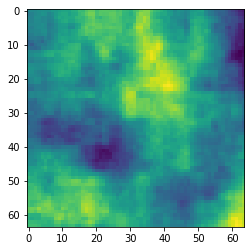

In [4]:
import matplotlib.pyplot as plt

kField = next(rfgen)
plt.imshow(kField[0])

In [5]:
import numpy as np
import pdb
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve # to use its short name
from collections import namedtuple

class InputError(Exception):
    pass

def unique(x, tol=0.0001):
    """return sorted unique values of x, keeping ascending or descending direction"""
    if x[0]>x[-1]:  # vector is reversed
        x = np.sort(x)[::-1]  # sort and reverse
        return x[np.hstack((np.diff(x) < -tol, True))]
    else:
        x = np.sort(x)
        return x[np.hstack((np.diff(x) > +tol, True))]

    
def fdm3t(gr, t, kx, ky, kz, Ss, FQ, HI, IBOUND, epsilon=0.67):
    '''Transient 3D Finite Difference Model returning computed heads and flows.
        
    Heads and flows are returned as 3D arrays as specified under output parmeters.
    
    Parameters
    ----------
    'gr' : `grid_object`, generated by gr = Grid(x, y, z, ..)
        if `gr.axial`==True, then the model is run in axially symmetric model
    t : ndarray, shape: [Nt+1]
        times at which the heads and flows are desired including the start time,
        which is usually zero, but can have any value.
    `kx`, `ky`, `kz` : ndarray, shape: (Nz, Ny, Nx), [L/T]
        hydraulic conductivities along the three axes, 3D arrays.
    `Ss` : ndarray, shape: (Nz, Ny, Nx), [L-1]
        specific elastic storage
    `FQ` : ndarray, shape: (Nz, Ny, Nx), [L3/T]
        prescrived cell flows (injection positive, zero of no inflow/outflow)
    `IH` : ndarray, shape: (Nz, Ny, Nx), [L]
        initial heads. `IH` has the prescribed heads for the cells with prescribed head.
    `IBOUND` : ndarray, shape: (Nz, Ny, Nx) of int
        boundary array like in MODFLOW with values denoting
        * IBOUND > 0  the head in the corresponding cells will be computed
        * IBOUND = 0  cells are inactive, will be given value NaN
        * IBOUND < 0  coresponding cells have prescribed head
    `epsilon` : float, dimension [-]
        degree of implicitness, choose value between 0.5 and 1.0
    
    outputs
    -------    
    `Out` : namedtuple containing heads and flows:
        `Out.Phi` : ndarray, shape: (Nt+1, Nz, Ny, Nx), [L3/T] 
            computed heads. Inactive cells will have NaNs
            To get heads at time t[i], use Out.Phi[i]
            Out.Phi[0] = initial heads
        `Out.Q`   : ndarray, shape: (Nt, Nz, Ny, Nx), [L3/T]
            net inflow in all cells during time step, inactive cells have 0
            Q during time step i, use Out.Q[i]
        `Out.Qs`  : ndarray, shape: (Nt, Nz, Ny, Nx), [L3/T]
            release from storage during time step.
        `Out.Qx   : ndarray, shape: (Nt, Nz, Ny, Nx-1), [L3/T] 
            intercell flows in x-direction (parallel to the rows)
        `Out.Qy`  : ndarray, shape: (Nt, Nz, Ny-1, Nx), [L3/T] 
            intercell flows in y-direction (parallel to the columns)
        `Out.Qz`  : ndarray, shape: (Nt, Nz-1, Ny, Nx), [L3/T] 
            intercell flows in z-direction (vertially upward postitive)        
    
    TO 161024
    '''

    import pdb
    
    # define the named tuple to hold all the output of the model fdm3
    Out = namedtuple('Out',['t', 'Phi', 'Q', 'Qs', 'Qx', 'Qy', 'Qz'])
    Out.__doc__ = """fdm3 output, <namedtuple>, containing fields `t`, `Phi`, `Q`, `Qs`, `Qx`, `Qy` and `Qz`\n \
                    Use Out.Phi, Out.Q, Out.Qx, Out.Qy and Out.Qz
                    or
                    Out.Phi[i] for the 3D heads of time `i`
                    Out.Q[i] for the 3D flows of time step `i`
                    Notice the difference between time and time step
                    The shape of Phi is (Nt + 1,Nz, Ny, Nx)
                    The shape of Q, Qs is (Nt, Nz, Ny, Nx)
                    For the other shapes see docstring of fdm_t                    
                    """                            
                                
    if gr.axial:
        print('Running in axial mode, y-values are ignored.')

    if kx.shape != gr.shape:
        raise AssertionError("shape of kx {0} differs from that of model {1}".format(kx.shape,gr.shape))
    if ky.shape != gr.shape:
        raise AssertionError("shape of ky {0} differs from that of model {1}".format(ky.shape,gr.shape))
    if kz.shape != gr.shape:
        raise AssertionError("shape of kz {0} differs from that of model {1}".format(kz.shape,gr.shape))
    if Ss.shape != gr.shape:
        raise AssertionError("shape of Ss {0} differs from that of model {1}".format(Ss.shape,gr.shape))
    
    active = (IBOUND>0).reshape(gr.Nod,)  # boolean vector denoting the active cells
    inact  = (IBOUND==0).reshape(gr.Nod,) # boolean vector denoting inacive cells
    fxhd   = (IBOUND<0).reshape(gr.Nod,)  # boolean vector denoting fixed-head cells

    # reshaping shorthands
    dx = np.reshape(gr.dx, (1, 1, gr.Nx))
    dy = np.reshape(gr.dy, (1, gr.Ny, 1))

    # half cell flow resistances
    if not gr.axial:
        Rx1 = 0.5 *    dx / (   dy * gr.DZ) / kx
        Rx2 = Rx1
        Ry1 = 0.5 *    dy / (gr.DZ *    dx) / ky
        Rz1 = 0.5 * gr.DZ / (   dx *    dy) / kz
    else:
        # prevent div by zero warning in next line; has not effect because x[0] is not used 
        x = gr.x.copy();  x[0] = x[0] if x[0]>0 else 0.1* x[1]
        
        Rx1 = 1 / (2 * np.pi * kx * gr.DZ) * np.log(x[1:] /  gr.xm).reshape((1, 1, gr.Nx))
        Rx2 = 1 / (2 * np.pi * kx * gr.DZ) * np.log(gr.xm / x[:-1]).reshape((1, 1, gr.Nx))
        Ry1 = np.inf * np.ones(gr.shape)
        Rz1 = 0.5 * gr.DZ / (np.pi * (gr.x[1:]**2 - gr.x[:-1]**2).reshape((1, 1, gr.Nx)) * kz)
    
    # set flow resistance in inactive cells to infinite
    Rx1[inact.reshape(gr.shape)] = np.inf
    Rx2[inact.reshape(gr.shape)] = np.inf
    Ry1[inact.reshape(gr.shape)] = np.inf
    Ry2 = Ry1
    Rz1[inact.reshape(gr.shape)] = np.inf
    Rz2 = Rz1
    
    # conductances between adjacent cells
    Cx = 1 / (Rx1[  :, :,  :-1] + Rx2[:, : , 1:])        
    Cy = 1 / (Ry1[  :, :-1,:  ] + Ry2[:, 1:, : ])
    Cz = 1 / (Rz1[:-1, :,  :  ] + Rz2[1:, :, : ])

    # storage term, variable dt not included
    Cs = (Ss * gr.Volume / epsilon).ravel()
        
    # cell number of neighboring cells
    IE = gr.NOD[  :, :,   1:] # east neighbor cell numbers
    IW = gr.NOD[  :, :,  :-1] # west neighbor cell numbers
    IN = gr.NOD[  :, :-1,  :] # north neighbor cell numbers
    IS = gr.NOD[  :, 1:,   :] # south neighbor cell numbers
    IT = gr.NOD[:-1, :,    :] # top neighbor cell numbers
    IB = gr.NOD[ 1:, :,    :] # bottom neighbor cell numbers
    
    R = lambda x : x.ravel()  # generate anonymous function R(x) as shorthand for x.ravel()
    
    # notice the call  csc_matrix( (data, (rowind, coind) ), (M,N))  tuple within tupple
    # also notice that Cij = negative but that Cii will be postive, namely -sum(Cij)
    A = sp.csc_matrix(( np.concatenate(( R(Cx), R(Cx), R(Cy), R(Cy), R(Cz), R(Cz)) ),\
                        (np.concatenate(( R(IE), R(IW), R(IN), R(IS), R(IB), R(IT)) ),\
                         np.concatenate(( R(IW), R(IE), R(IS), R(IN), R(IT), R(IB)) ),\
                      )), (gr.Nod,gr.Nod))

    A = -A + sp.diags(np.array(A.sum(axis=1))[:,0]) # Change sign and add diagonal
   
    #Initialize output arrays (= memory allocation)
    Nt = len(t)-1
    Out.Phi = np.zeros((Nt+1, gr.Nod)) # Nt+1 times
    Out.Q   = np.zeros((Nt  , gr.Nod)) # Nt time steps
    Out.Qs  = np.zeros((Nt  , gr.Nod))
    Out.Qx  = np.zeros((Nt, gr.Nz, gr.Ny, gr.Nx-1))
    Out.Qy  = np.zeros((Nt, gr.Nz, gr.Ny-1, gr.Nx))
    Out.Qz  = np.zeros((Nt, gr.Nz-1, gr.Ny, gr.Nx))
    
    # reshape input arrays to vectors for use in system equation
    FQ = R(FQ);  HI = R(HI);  Cs = R(Cs)
    
    # initialize heads
    Out.Phi[0] = HI
    
    # solve heads at active locations at t_i+eps*dt_i
    
    Nt=len(t)  # for heads, at all times Phi at t[0] = initial head
    Ndt=len(np.diff(t)) # for flows, average within time step
    
    for idt, dt in enumerate(np.diff(t)):
        
        it = idt + 1 
        
        # this A is not complete !!
        RHS = FQ - (A + sp.diags(Cs / dt))[:,fxhd].dot(Out.Phi[it-1][fxhd]) # Right-hand side vector

        Out.Phi[it][active] = spsolve( (A + sp.diags(Cs / dt))[active][:,active],
                                  RHS[active] + Cs[active] / dt * Out.Phi[it-1][active])
    
        # net cell inflow
        Out.Q[idt]  = A.dot(Out.Phi[it])

        Out.Qs[idt] = -Cs/dt * (Out.Phi[it]-Out.Phi[it-1])


        #Flows across cell faces
        Out.Qx[idt] =  -np.diff( Out.Phi[it].reshape(gr.shape), axis=2) * Cx
        Out.Qy[idt] =  +np.diff( Out.Phi[it].reshape(gr.shape), axis=1) * Cy
        Out.Qz[idt] =  +np.diff( Out.Phi[it].reshape(gr.shape), axis=0) * Cz

        # update head to end of time step
        Out.Phi[it] = Out.Phi[it-1] + (Out.Phi[it] - Out.Phi[it-1]) / epsilon

    # reshape Phi to shape of grid
    Out.Phi = Out.Phi.reshape((Nt,) + gr.shape)
    Out.Q   = Out.Q.reshape( (Ndt,) + gr.shape)
    Out.Qs  = Out.Qs.reshape((Ndt,) + gr.shape)

    return Out # all outputs in a named tuple for easy access

In [7]:
nx = 64
ny = 1 
nz = 64

x = np.linspace(0, 10, nx+1)
y = np.linspace(-0.5, 0.5, ny+1)
z = np.linspace(0, 10, nz+1)

gr = Grid(x,y,z)

t = np.array(range(0,1000))

kx = ky = kz = np.full((nx, ny, nz), 10)
kx = ky = kz = next(rfgen)[0].reshape(nx, ny, nz)

Ss = np.full((nx, ny, nz), 1)
FQ = np.zeros((nx, ny, nz))
FQ[5, 0, 5] = -10000

IH = np.zeros((nx, ny, nz))
IH[:, 0,  0] = 10
IH[:, 0, -1] = 10
IH[0, 0,  :] = 10
IH[-1, 0, :] = 10

IBOUND = np.ones((nx, ny, nz))
IBOUND[:, 0,  0] = -1
IBOUND[:, 0, -1] = -1
IBOUND[0, 0,  :] = -1
IBOUND[-1, 0, :] = -1

In [8]:
Out = fdm3t(gr, t, kx, ky, kz, Ss, FQ, IH, IBOUND, epsilon=0.67)

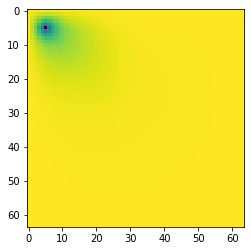

In [9]:
plt.imshow(Out.Phi[998][:,0,:])
